In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf

tf.__version__

'2.2.0-rc2'

In [0]:
from tensorflow.keras.datasets import mnist
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

In [5]:
xtrain.shape, ytrain.shape

((60000, 28, 28), (60000,))

In [6]:
xtest.shape, ytest.shape

((10000, 28, 28), (10000,))

3


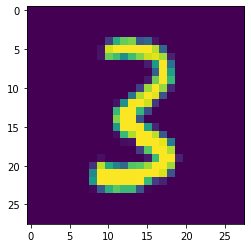

In [9]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[50000])
print(ytrain[50000])

In [0]:
xtrain = xtrain/255

In [0]:
xtest = xtest/255

In [0]:
from tensorflow.keras.utils import to_categorical

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD


In [0]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(1024,activation=relu))
model.add(Dense(256,activation=relu))
model.add(Dense(10,activation=softmax))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 1,068,810
Trainable params: 1,068,810
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss=categorical_crossentropy, metrics=["acc"])

In [18]:
model.fit(xtrain, ytrain,batch_size=256, epochs=10, validation_split=0.2)

Epoch 1/10
188/188 [==============================] - 7s 35ms/step - loss: 0.3022 - acc: 0.9054 - val_loss: 0.1389 - val_acc: 0.9578
Epoch 2/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0995 - acc: 0.9692 - val_loss: 0.1365 - val_acc: 0.9595
Epoch 3/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0625 - acc: 0.9804 - val_loss: 0.0893 - val_acc: 0.9743
Epoch 4/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0401 - acc: 0.9872 - val_loss: 0.0849 - val_acc: 0.9756
Epoch 5/10
188/188 [==============================] - 6s 34ms/step - loss: 0.0272 - acc: 0.9912 - val_loss: 0.1107 - val_acc: 0.9722
Epoch 6/10
188/188 [==============================] - 6s 34ms/step - loss: 0.0214 - acc: 0.9933 - val_loss: 0.1090 - val_acc: 0.9749
Epoch 7/10
188/188 [==============================] - 7s 35ms/step - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0972 - val_acc: 0.9777
Epoch 8/10
188/188 [==============================] - 7s 35ms/step - 

In [0]:
from tensorflow.keras.models import save_model
import os

In [0]:
#!rm -rf mnist_model/

In [23]:
version = 1
!mkdir -p mnist_model/{version}
save_model(model, filepath=os.path.join("mnist_model",str(version)))

INFO:tensorflow:Assets written to: mnist_model/1/assets


In [24]:

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl -s https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt -qq update 

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
OK
54 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [25]:
# Download the TensorFlow Serving 
!apt-get -qq install  tensorflow-model-server

Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.1.0_all.deb ...
Unpacking tensorflow-model-server (2.1.0) ...
Setting up tensorflow-model-server (2.1.0) ...


In [27]:
!pwd

/content


In [52]:
# This will start the server against the host where model will be deployed and exposed from
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=predictMnist --model_base_path="/content/mnist_model" >> /content/mnist_model.log

Starting job # 2 in a separate thread.


In [33]:
#%%bash
#!tail -f /content/mnist_model.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 238] NET_LOG: Entering the event loop ...
^C


In [35]:
#!cat /content/mnist_model.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 238] NET_LOG: Entering the event loop ...


In [36]:
!type hostname


hostname is /bin/hostname


In [0]:
import requests


In [0]:
def predict(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post("http://localhost:8501/v1/models/predictMnist:predict",data=data, headers= headers)
  json_result = json.loads(json_response.text)
  return json_result



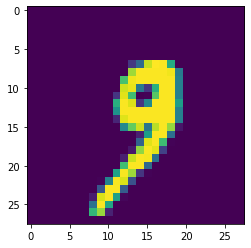

In [40]:
plt.imshow(xtest[1000])

In [0]:
import json

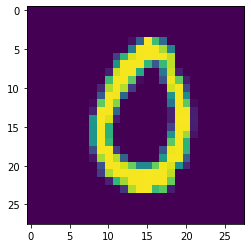

In [65]:
predicted_response = predict(json.dumps({"signature_name": "serving_default","instances":xtest[1001].tolist()}))
plt.imshow(xtest[1001])

In [66]:
import numpy as np
np.argmax(predicted_response["predictions"])

0

In [69]:
!ps -eaf | grep tensorflow-model-server

root        2886     119  0 16:28 ?        00:00:00 /bin/bash -c ps -eaf | grep tensorflow-model-server
root        2888    2886  0 16:28 ?        00:00:00 grep tensorflow-model-server


In [70]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      8 ?        00:00:07 node
     18 ?        00:00:15 jupyter-noteboo
    110 ?        00:00:00 tail
    119 ?        00:02:14 python3
   2730 ?        00:00:00 bash
   2732 ?        00:00:00 tensorflow_mode
   2895 ?        00:00:00 ps
